In [1]:
import numpy as np
import os
np.random.seed(42)

In [2]:

# Create arrays with filenames and lables
inFile = open("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/train-grouped.txt", "r")

all_images = {}
all_labels = {}
# exclude last group (30mph) beacuse there is so few 
for i in range(6):
    all_images[i] = []
for i, v in enumerate(inFile):
    if int(v)//5 < 6:
        #add the ith image to its group
        all_images[int(v)//5].append(str(i)+".jpg")
        all_labels[str(i)+".jpg"] = int(v)//5
    
min_size = int(1e9)
for i in range(6):
    min_size = min(len(all_images[i]), min_size)
    np_arr = np.array(all_images[i])
    all_images[i] = np_arr
    print(np_arr.shape)

print(min_size)


(2496,)
(2597,)
(4553,)
(3141,)
(2015,)
(4820,)
2015


In [3]:
train_images = {}
val_images = {}
test_images = {}
for i in range(6):
    np.random.shuffle(all_images[i])
    train_images[i] = all_images[i][:1400]
    val_images[i] = all_images[i][1400:1700]
    test_images[i] = all_images[i][1700:2000]
    print(i, "mph group dataset: ", train_images[i].shape, val_images[i].shape, test_images[i].shape)

0 mph group dataset:  (1400,) (300,) (300,)
1 mph group dataset:  (1400,) (300,) (300,)
2 mph group dataset:  (1400,) (300,) (300,)
3 mph group dataset:  (1400,) (300,) (300,)
4 mph group dataset:  (1400,) (300,) (300,)
5 mph group dataset:  (1400,) (300,) (300,)


In [4]:
train_images_all = np.concatenate([train_images[x] for x in train_images])
val_images_all = np.concatenate([val_images[x] for x in val_images])
test_images_all = np.concatenate([test_images[x] for x in test_images])

train_images_all.shape, val_images_all.shape

((8400,), (1800,))

In [5]:
np.random.shuffle(train_images_all)
np.random.shuffle(val_images_all)
np.random.shuffle(test_images_all)

In [6]:
s = np.concatenate([train_images_all] + [val_images_all] + [test_images_all])
print(len(s))
s = set(s)
print(len(s))
if len(train_images_all)+len(val_images_all)+len(test_images_all) != len(s):
    print("Datasets has crossover")
else:
    print("Dataset is good")

12000
12000
Dataset is good


In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [8]:
IMG_DIM = (150, 150)

train_images_array = [img_to_array(load_img("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/frames/"+img, target_size=IMG_DIM)) for img in train_images_all]
train_images_array = np.array(train_images_array)

val_images_array = [img_to_array(load_img("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/frames/"+img, target_size=IMG_DIM)) for img in val_images_all]
val_images_array = np.array(val_images_array)

print('Train dataset shape:', train_images_array.shape, 
      '\tValidation dataset shape:', val_images_array.shape)


Train dataset shape: (8400, 150, 150, 3) 	Validation dataset shape: (1800, 150, 150, 3)


In [9]:
train_labels = []
for fn in train_images_all:
    train_labels.append(all_labels[fn])
    
val_labels = []
for fn in val_images_all:
    val_labels.append(all_labels[fn])

print("labels length: ", len(train_labels), len(val_labels))

labels length:  8400 1800


In [10]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(val_labels)

validation_labels_enc

array([3, 5, 1, ..., 2, 1, 1], dtype=int64)

(150, 150, 3)


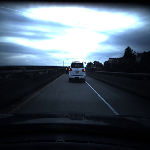

In [11]:
train_imgs_scaled = train_images_array.astype('float32')
validation_imgs_scaled  = val_images_array.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_images_array[0].shape)
array_to_img(train_images_array[0])

In [12]:
from keras.applications import vgg16
from keras.models import Model
import keras
import pandas as pd

In [13]:
#25 devides both 1400 and 300
batch_size = 25
#remember, we excluded the last class
num_classes = 6
epochs = 20
input_shape = (150, 150, 3)

In [14]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

In [15]:
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)


In [16]:
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [17]:
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016075F64B50>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000161F82AFB20>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000161F832C340>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000161F82AFFA0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000161F83CB5E0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000161F83D46A0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000161F83D4370>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000161F83BADC0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000161F83C1F70>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000161F83DA070>,block3_conv3,False


(1, 4, 4, 512)


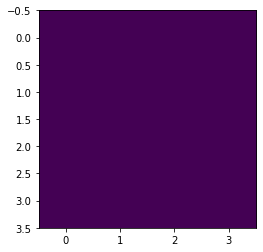

In [18]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [19]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=1)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

57/57 [==============================] - 220s 4s/step
Train Bottleneck Features: (8400, 8192) 	Validation Bottleneck Features: (1800, 8192)


In [20]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

In [21]:
input_shape = vgg_model.output_shape[1]
input_shape

8192

In [22]:
model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='sigmoid'))


In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total params: 4,460,550
Trainable params: 4,460,550
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/20
336/336 [==============================] - 30s 84ms/step - loss: 1.2312 - accuracy: 0.5039 - val_loss: 0.5041 - val_accuracy: 0.8156
Epoch 2/20
336/336 [==============================] - 27s 79ms/step - loss: 0.4898 - accuracy: 0.8082 - val_loss: 0.2801 - val_accuracy: 0.9011
Epoch 3/20
336/336 [==============================] - 26s 78ms/step - loss: 0.2873 - accuracy: 0.8962 - val_loss: 0.2409 - val_accuracy: 0.9000
Epoch 4/20
336/336 [==============================] - 26s 78ms/step - loss: 0.2067 - accuracy: 0.9246 - val_loss: 0.1899 - val_accuracy: 0.9233
Epoch 5/20
336/336 [==============================] - 26s 78ms/step - loss: 0.1702 - accuracy: 0.9391 - val_loss: 0.1743 - val_accuracy: 0.9300
Epoch 6/20
336/336 [==============================] - 26s 79ms/step - loss: 0.1423 - accuracy: 0.9476 - val_loss: 0.1042 - val_accuracy: 0.9594
Epoch 7/20
336/336 [==============================] - 27s 79ms/step - loss: 0.1265 - accuracy: 0.9521 - val_loss: 0.0792 - val_accuracy:

In [26]:
model.save('model_classify_frames_v2.h5')

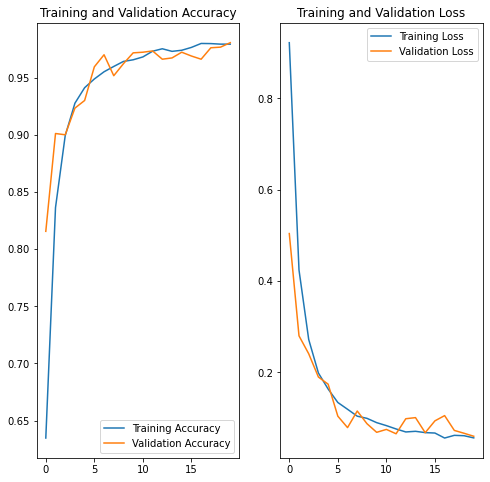

In [27]:
#plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(150, 150, 3)


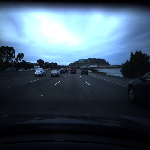

In [28]:
test_images_array = [img_to_array(load_img("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/frames/"+img, target_size=IMG_DIM)) for img in test_images_all]
test_images_array = np.array(test_images_array)

test_imgs_scaled = test_images_array.astype('float32')
test_imgs_scaled /= 255

print(test_images_array[0].shape)
array_to_img(test_images_array[0])

In [29]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)


57/57 [==============================] - 220s 4s/step


In [30]:
predicted_ids = model.predict_classes(test_bottleneck_features, verbose=1)
predicted_class_names = [i * 5 for i in predicted_ids]


C:\Users\Lukas\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:459: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


57/57 [==============================] - 1s 9ms/step


In [31]:
test_labels = []
for fn in test_images_all:
    test_labels.append(all_labels[fn])


In [32]:
results = model.evaluate(test_bottleneck_features, np.array(test_labels), batch_size=batch_size)


72/72 [==============================] - 1s 10ms/step - loss: 0.0740 - accuracy: 0.9772
